We will look at the performance of Pnet against:
 - an equally sparse but randomly connected feed forward neural network (sparseNN)
 - a fully connected feed forward neural network (fcNN)
 - a random forest classifier model (RF)
 - a svm classifier model (SVM)

The benchmarking task is done on the original prostate dataset from the 2019 paper

### Loading the data

In [1]:
import pnet_loader
import util
import Pnet
import torch
import random
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import torch.nn.functional as F
import torch.nn as nn


%load_ext autoreload
%autoreload 2

In [2]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_genes = pd.read_csv('../../data/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
# prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

Generate train test splits for 10 fold CV, not to run again if saved splits are available

In [3]:
# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# random.shuffle(prostate_inds)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
        
# test_splits = chunks(prostate_inds, int(len(prostate_inds)/10)+1)
# for i, s in enumerate(test_splits):
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, test_inds=s)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

In [4]:
# from sklearn.model_selection import StratifiedKFold

# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# y = list(prostate_response.loc[prostate_inds]['response'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=10)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(prostate_inds, y):
#     sublist = [prostate_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in prostate_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

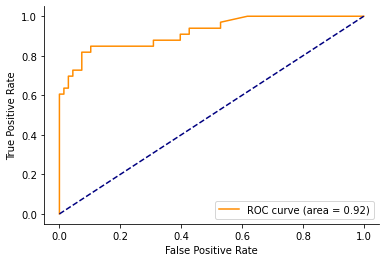

In [6]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_geneset(genetic_data, prostate_response, 
                                                                                     geneset_path='/mnt/disks/pancan/pnet/data/hallmark/h.all.v2022.1.Hs.symbols.gmt',
                                                                                     seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, 
                                                                                     save_path='../results/prostate_val_hallmark/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), genes=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_hallmark/run{}'.format(i))

In [7]:
# model.interpret_flag=True
# cond = captum.attr.LayerConductance(model, model.first_gene_layer)  # ReLU output of masked layer at each level
# cond_vals = cond.attribute((test_dataset.x, test_dataset.additional), target=0)
# cols = [model.reactome_network.pathway_encoding.set_index('ID').loc[col]['pathway'] for col in model.reactome_network.pathway_layers[0].index]
# cond_vals_genomic = pd.DataFrame(cond_vals.detach().numpy(),
#                                  columns=cols,
#                                  index=test_dataset.input_df.index)
# pathway_imp_by_target = cond_vals_genomic
# model.interpret_flag=False
# pathway_imp_by_target

In [8]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_hallmark/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc)
pnet_aucs

[tensor(0.8932),
 tensor(0.9004),
 tensor(0.8196),
 tensor(0.9140),
 tensor(0.8957),
 tensor(0.8870),
 tensor(0.9332),
 tensor(0.8632),
 tensor(0.8770),
 tensor(0.9189)]

In [9]:
torch.tensor(pnet_aucs).mean()

tensor(0.8902)

In [10]:
torch.tensor(pnet_aucs).mean()

tensor(0.8902)

Pnet performance:

In [ ]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/run{}'.format(i))

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

In [12]:
# for i in range(10):
#     train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
#     test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
#     model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, lr=1e-3, weight_decay=1,
#                                                                            batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
#                                                                            test_inds=test_inds)
#     plt.clf()
#     Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/run{}'.format(i))

In [15]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc)
pnet_aucs

[tensor(0.8711),
 tensor(0.9183),
 tensor(0.8837),
 tensor(0.9349),
 tensor(0.8895),
 tensor(0.8973),
 tensor(0.9033),
 tensor(0.8512),
 tensor(0.8636),
 tensor(0.9011)]

In [16]:
torch.tensor(pnet_aucs).mean()

tensor(0.8914)

Pnet but with random gene and pathway connections:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

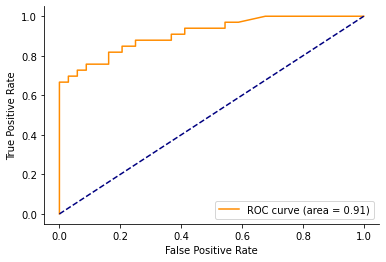

In [20]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val_random_net/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes, random_network=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_random_net/run{}'.format(i))

In [21]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_random_net/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.8901383876800537,
 0.9148375988006592,
 0.8792800307273865,
 0.936274528503418,
 0.8373440504074097,
 0.8672013878822327,
 0.8899286985397339,
 0.8658645153045654,
 0.8841354846954346,
 0.9117647409439087]

0.8850

In [22]:
torch.tensor(pnet_aucs).median()

tensor(0.8841)

Pnet but as a fully connected feed forward neural network:

Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Found 443 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping gene

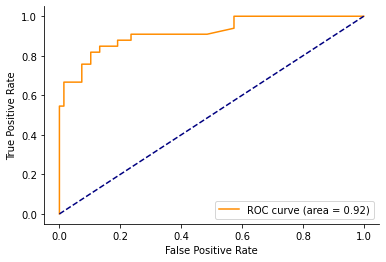

In [17]:
class_weights = util.get_class_weights(torch.tensor(prostate_response.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3, weight_decay=1e-3,
                                                                               batch_size=64, epochs=400, early_stopping=True, train_inds=train_inds,
                                                                               test_inds=test_inds, loss_weight=class_weights, save_path='../results/prostate_val_fcnn/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes, fcnn=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_fcnn/run{}'.format(i))

In [18]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_fcnn/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.9061418771743774,
 0.881913959980011,
 0.8353818655014038,
 0.7776292562484741,
 0.9135472178459167,
 0.9106506109237671,
 0.9073083400726318,
 0.864973247051239,
 0.8542781472206116,
 0.917557954788208]

In [19]:
torch.tensor(pnet_aucs).median()

tensor(0.8819)

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated inpu

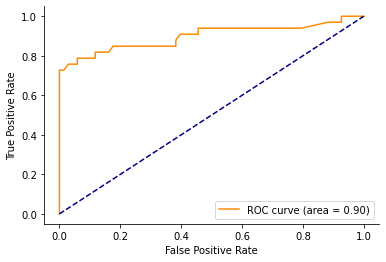

In [76]:
for i in range(10):
    path = '../results/prostate_val_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [77]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val_rf/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.8990051746368408,
 0.8966199159622192,
 0.8597453832626343,
 0.8747771978378296,
 0.8957219123840332,
 0.8778966069221497,
 0.9097594022750854,
 0.8611854314804077,
 0.8545008897781372,
 0.898172914981842]

In [78]:
torch.tensor(pnet_aucs).median()

tensor(0.8779)

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (909, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (102, 1329)
1329
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
1329
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes
generated input DataFrame of size (101, 1329)
1329
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 443 overlapping genes
generated input DataFrame of size (910, 1329)
Initializing Test Dataset
Found 443 overlapping genes

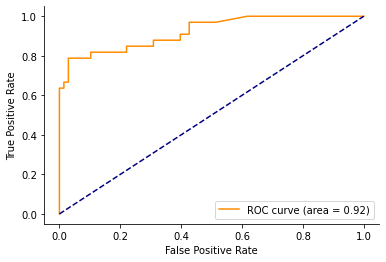

In [100]:
for i in range(10):
    path = '../results/prostate_val_svm/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    svm = SVC(gamma='auto', kernel='linear', probability=True)
    svm.fit(x_train, y_train)
    
    preds = svm.predict(x_test)
    preds_prob = svm.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = svm.coef_
    print(len(importances[0]))
    svm_importances = pd.Series(importances[0], index=test_dataset.input_df.columns)
    svm_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')
    

### Generate Figures

In [84]:
auc_df = pd.DataFrame()
models = ['prostate_val', 'prostate_val_fcnn']
for mod in models:
    aucs = []
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(mod, i))
        aucs.append(auc.item())
    auc_df[mod] = aucs
models = ['prostate_val_rf', 'prostate_val_svm']
for mod in models:
    aucs = []
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(mod, i))
        aucs.append(auc.item())
    auc_df[mod] = aucs
auc_df

auc_df = auc_df[auc_df.mean().sort_values(ascending=False).index]
auc_df.rename(columns={'prostate_val': 'P-Net', 'prostate_val_fcnn': 'FCNN', 'prostate_val_hallmark': 'Hallmark-NN',
       'prostate_val_svm': 'SVM', 'prostate_val_rf': 'RF'}, inplace=True)

In [85]:
auc_df.mean()

P-Net    0.891399
RF       0.882738
FCNN     0.876938
SVM      0.851599
dtype: float64

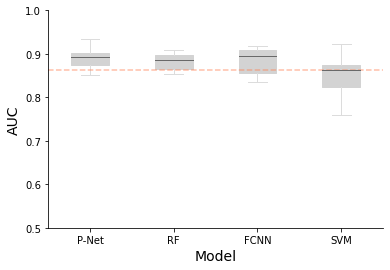

In [86]:
auc_df.plot(kind='box', showfliers=False, patch_artist=True, boxprops={'facecolor': 'lightgrey', 'color': 'lightgrey'},
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
plt.axhline(y=auc_df.median().min(), color='coral', linestyle='--', label=f'y_min = {auc_df.median().min()}', alpha=0.5)
ax.set_ylabel('AUC', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/pnet_performance_benchmark_AUC.pdf')

In [4]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

In [6]:
df_imps.mean(axis=1).nlargest(20)

AR        1.268283
PTEN      0.584889
TP53      0.574083
UBR5      0.374639
RB1       0.356330
ELK4      0.355402
MDM4      0.355074
SMAD3     0.337494
ZEB1      0.331075
CDKN1A    0.326315
COL3A1    0.319495
CHIC2     0.314691
EPHA7     0.310444
BLM       0.306061
FBXW7     0.306061
MUC4      0.303685
ITK       0.303598
TERT      0.299557
PRDM1     0.298776
TET1      0.296017
dtype: float64

In [14]:
df_imps_fcnn = pd.DataFrame()
df_ranks_fcnn = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_fcnn/run{}/gene_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1]
    ranks = imps.rank(ascending=False)
    df_imps_fcnn['run{}'.format(i)] = imps
    df_ranks_fcnn['run{}'.format(i)] = ranks

In [15]:
df_imps_rf = pd.DataFrame()
df_ranks_rf = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    ranks = imps.rank(ascending=False)
    df_imps_rf['run{}'.format(i)] = imps
    df_ranks_rf['run{}'.format(i)] = ranks
    
num_sections = 3
section_size = len(df_imps_rf) // num_sections

# Split the original DataFrame into three sub-sections
dfs = [df_imps_rf[i * section_size : (i + 1) * section_size] for i in range(num_sections)]

for df in dfs:
    df.index = [ind.split('_')[0] for ind in dfs[1].index]

# Sum the sub-sections element-wise to obtain the final DataFrame
df_imps_rf = dfs[0] + dfs[1] + dfs[2]

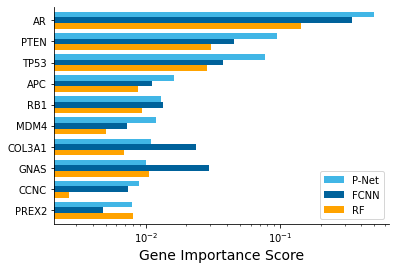

In [16]:
plotting_df = pd.DataFrame()
custom_colors = {'P-Net': '#41B6E6', 'FCNN': '#00629B', 'RF':'#FFA300'}
plotting_df['P-Net'] = df_imps.mean(axis=1).nlargest(10)/df_imps.mean(axis=1).sum()
plotting_df['FCNN'] = df_imps_fcnn.loc[df_imps.mean(axis=1).nlargest(10).index].mean(axis=1)/df_imps_fcnn.mean(axis=1).sum()
plotting_df['RF'] = df_imps_rf.loc[df_imps.mean(axis=1).nlargest(10).index].mean(axis=1)/df_imps_rf.mean(axis=1).sum()
plotting_df.plot(kind='barh', color=custom_colors, width=0.8)
sns.despine()
plt.gca().invert_yaxis()
plt.xlabel('Gene Importance Score', size='14')
plt.xscale('log')
plt.savefig('../figures/prostate_metastatic_top_genes.pdf')

In [55]:
df_imps = pd.DataFrame()
df_ranks = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    df_imps['run{}'.format(i)] = imps
    df_ranks['run{}'.format(i)] = ranks

In [56]:
df_imps_fcnn = pd.DataFrame()
df_ranks_fcnn = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_fcnn/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
    ranks = imps.rank(ascending=False)
    df_imps_fcnn['run{}'.format(i)] = imps
    df_ranks_fcnn['run{}'.format(i)] = ranks

In [57]:
df_imps_rf = pd.DataFrame()
df_ranks_rf = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_rf/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps)
    ranks = imps.rank(ascending=False)
    df_imps_rf['run{}'.format(i)] = imps
    df_ranks_rf['run{}'.format(i)] = ranks

In [58]:
df_imps_svm = pd.DataFrame()
df_ranks_svm = pd.DataFrame()
for i in range(10):
    imps = pd.read_csv('../results/prostate_val_svm/run{}/gene_feature_importances.csv'.format(i)).set_index('Unnamed: 0')
    imps = abs(imps)
    ranks = imps.rank(ascending=False)
    df_imps_svm['run{}'.format(i)] = imps
    df_ranks_svm['run{}'.format(i)] = ranks

In [59]:
import numpy as np

In [60]:
def stability_score_bootstrap(imps, top_n, n_subs, boots):
    scores = []
    for b in range(boots):
        imps_ = imps.sample(n_subs, axis=1)
        overlaps = []
        for c1 in imps_.columns:
            for c2 in imps_.columns:
                if c1 > c2:
                    overlaps.append(len(set(imps_.nlargest(top_n, c1).index).intersection(set(imps_.nlargest(top_n, c2).index))))
        scores.append(sum(overlaps)/(imps_.shape[1]*(imps_.shape[1]-1)/2*top_n))
    return np.std(scores)

In [61]:
def stability_score(imps, top_n):
    overlaps = []
    for c1 in imps.columns:
        for c2 in imps.columns:
            if c1 > c2:
                overlaps.append(len(set(imps.nlargest(top_n, c1).index).intersection(set(imps.nlargest(top_n, c2).index))))
    return sum(overlaps)/(imps.shape[1]*(imps.shape[1]-1)/2*top_n)

In [62]:
imps_list = [df_imps, df_imps_fcnn, df_imps_rf, df_imps_svm]

In [63]:
n_genes = [1, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200]
p_net_stab = [stability_score(df_imps, n) for n in n_genes]
p_net_stab_var = [stability_score_bootstrap(df_imps, n, 4, 100) for n in n_genes]

f_net_stab = [stability_score(df_imps_fcnn, n) for n in n_genes]
f_net_stab_var = [stability_score_bootstrap(df_imps_fcnn, n, 4, 100) for n in n_genes]

rf_stab = [stability_score(df_imps_rf, n) for n in n_genes]
rf_stab_var = [stability_score_bootstrap(df_imps_rf, n, 4, 100) for n in n_genes]

svm_stab = [stability_score(df_imps_svm, n) for n in n_genes]
svm_stab_var = [stability_score_bootstrap(df_imps_svm, n, 4, 100) for n in n_genes]

plt_df = pd.DataFrame(index=n_genes)
plt_df['P-Net'] = p_net_stab
plt_df['FCNN'] = f_net_stab
plt_df['RF'] = rf_stab
plt_df['SVM'] = svm_stab

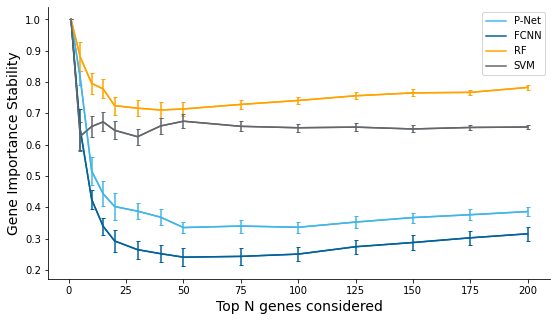

In [72]:
error_fcnn = np.array(f_net_stab_var)
lower_fcnn = np.array(f_net_stab) - error_fcnn
upper_fcnn = np.array(f_net_stab) + error_fcnn

error_pnet = np.array(p_net_stab_var)
lower_pnet = np.array(p_net_stab) - error_pnet
upper_pnet = np.array(p_net_stab) + error_pnet

error_rf = np.array(rf_stab_var)
lower_rf = np.array(rf_stab) - error_rf
upper_rf = np.array(rf_stab) + error_rf

error_svm = np.array(svm_stab_var)
lower_svm = np.array(svm_stab) - error_svm
upper_svm = np.array(svm_stab) + error_svm

fig, ax = plt.subplots(figsize=(9,5))
plt_df.plot(ax=ax, color={'P-Net':'#41B6E6', 'FCNN':'#00629B', 'RF':'#FFA300', 'SVM':'#63666A'})
ax.errorbar(n_genes, np.array(f_net_stab), error_fcnn, color='#00629B', ecolor='#00629B', capsize=2)
ax.errorbar(n_genes, np.array(p_net_stab), error_pnet, color='#41B6E6', ecolor='#41B6E6', capsize=2)
ax.errorbar(n_genes, np.array(rf_stab), error_rf, color='#FFA300', ecolor='#FFA300', capsize=2)
ax.errorbar(n_genes, np.array(svm_stab), error_rf, color='#63666A', ecolor='#63666A', capsize=2)
sns.despine()
ax.set_xlabel('Top N genes considered', size=14)
ax.set_ylabel('Gene Importance Stability', size=14)

plt.savefig('../figures/importance_stability_n_genes.pdf')
plt.show()

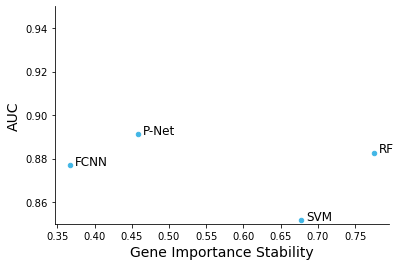

In [87]:
df = pd.DataFrame(index=['P-Net', 'FCNN', 'RF', 'SVM'])
df['AUC'] = auc_df.mean()
df['Gene Importance Stability'] = plt_df.mean()

df.plot(kind='scatter', x='Gene Importance Stability', y='AUC', color='#41B6E6')
sns.despine()
for index, row in df.iterrows():
    plt.annotate(index, (row['Gene Importance Stability'], row['AUC']), xytext=(5, 0), textcoords='offset points', fontsize=12)
plt.ylim((0.85, 0.95))
plt.xlabel('Gene Importance Stability', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.savefig('../figures/pnet_performance_gene_variance.pdf')
plt.show()

In [65]:
# all_imps = pd.DataFrame(columns=['Run', 'Importance', 'Model', 'Layer'])
# for m in ['val', 'val_random_net']:
#     for l in ['gene_feature', 'gene', 'layer_0', 'layer_1', 'layer_2', 'layer_3']:
#         df_imps = pd.DataFrame()
#         df_ranks = pd.DataFrame()
#         for i in range(10):
#             imps = pd.read_csv('../results/prostate_{}/run{}/{}_importances.csv'.format(m, i, l)).set_index('Unnamed: 0')
#             imps = abs(imps.join(prostate_response).groupby('response').mean().diff(axis=0).iloc[1])
#             ranks = imps.rank(ascending=False)
#             df_imps['run{}'.format(i)] = imps
#             df_ranks['run{}'.format(i)] = ranks
#         melted_imps = df_imps.melt(value_name='Importance', var_name='Run')
#         melted_imps['Model'] = m
#         melted_imps['Layer'] = l
#         all_imps = pd.concat([all_imps, melted_imps])
# all_imps

In [149]:
# layer_numeric = {'gene_feature':0, 'gene':1, 'layer_0':2, 'layer_1':3, 'layer_2':4, 'layer_3':5}

In [150]:
# all_imps['Numeric Layer'] = all_imps['Layer'].apply(lambda x: layer_numeric[x])

In [66]:
# plt.figure(figsize=(24, 16))
# sns.scatterplot(data=all_imps, y='Importance', x='Numeric Layer', hue='Model')
# plt.show()

In [153]:
# grpd_df = all_imps.groupby(['Numeric Layer', 'Model']).mean().reset_index()
# std_df = all_imps.groupby(['Numeric Layer', 'Model']).std().reset_index()
# grpd_df['Importance'] = grpd_df['Importance']/std_df['Importance']

In [67]:
# sns.lineplot(data=grpd_df, x='Numeric Layer', y='Importance', hue='Model')
# plt.legend(['P-Net', 'Random Sparse Net'])
# plt.ylabel('SNR of Importance Scores', size=14)
# plt.xlabel('Network Layer', size=14)
# sns.despine()
# plt.savefig('../figures/importance_scores_per_layer_SNR.pdf')

In [ ]:
def plot_violin(dataframe, title, ax):
    melted_df = dataframe.melt(var_name='Columns', value_name='Values')
    sns.violinplot(y='Values', data=melted_df, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Columns', size=14)
    ax.set_ylabel('Values', size=14)

# Create subplots for each violin plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax2.spines[['top','left','right']].set_visible(False)
ax1.spines[['top','right']].set_visible(False)
ax2.yaxis.set_visible(False)
# Plot the first DataFrame as violin plot
plot_violin(df_imps, title='P-Net', ax=ax1)

# Plot the second DataFrame as violin plot
plot_violin(df_imps_rand, title='Sparse-NN', ax=ax2)

In [ ]:
df_imps_rand.mean(axis=1).nlargest(20)